裝袋法也是一種多數決的方法。其步驟如下:

1. 假設現在有一個有n筆資料的資料集，我們每次取n個，取後放回，重複k次，得到k個子集合
2. 利用相同的演算法，將這k個子集合拿去訓練出k個模型
3. 就每個模型之預測進行多數決

如果我們用決策樹來實作這個演算法，加上一些規則，其實就會得到隨機森林。scikit learn有實作出裝袋法，可以直接引用。我們用葡萄酒數據集來說明。為方便起見，只選擇兩類別與兩特徵。

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 這裡做的事情跟Ch4 ch5一模一樣
df_wine = pd.read_csv('wine.data', header=None) # open the wine dataset

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [2]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 引進決策樹演算法，我們故意不做修剪，讓他一直長下去
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)

# 進行裝袋
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,  # 500個model進行多數決
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

# 為了做比較，先只用一棵樹做fitting
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

# 單一一棵樹的效能
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

# 裝袋演算法的效能
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

# 裝袋演算法的效能
bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('Bagging train/test accuracies %.3f/%.3f'
      % (bag_train, bag_test))

Decision tree train/test accuracies 1.000/0.833
Bagging train/test accuracies 1.000/0.917


我們發現單一一顆決策樹對訓練集有100%正確率，對測試集卻只有83.3%，很明顯地，這樣就overfitting了(因為我們沒有修剪)。接著我們繪製看看決策邊界，以了解為何會發生這種事。

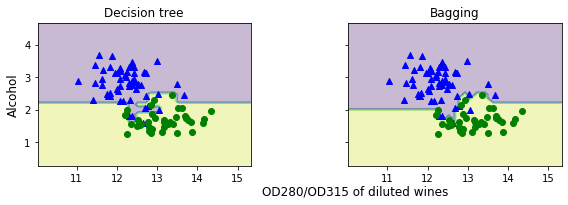

In [4]:
import numpy as np
import matplotlib.pyplot as plt

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -0.5,
         s='OD280/OD315 of diluted wines',
         ha='center', va='center', fontsize=12)

plt.tight_layout()
#plt.savefig('images/07_08.png', dpi=300, bbox_inches='tight')
plt.show()

可以看到單一一顆決策樹長出了異常崎嶇的邊界，這是overfitting常見的特徵。